In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
 
import tidy3d as td
from tidy3d.plugins.mode import ModeSolver
from tidy3d import web
from tidy3d import SpatialDataArray

# import scienceplots
# plt.style.use(['science','nature'])
 

In [2]:
########################################################################################
#! Waveguide BTO info
wg_height = 0.1
wg_width = 1

#! BTO substrate info
bto_height = 0.2

#! STO info
sto_height = 0.01

#! SiO2 info
sio2_height = 2

#! Si info
si_height = 8

#! Permittivity of waveguide and substrate
si_eps = 3.48**2
sio2_eps = 1.45**2
sto_eps = 2.284**2
bto_eps = np.array([5.76, 5.76, 5.29])

#! Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0/lambda0
ldas = np.linspace(1.5, 1.6, 100)  # consider the range of the frequency.
freqs = td.C_0/ldas
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))

#! Simulation size inside the PML along propagation direction 
sim_length = 20 #um

#! space between waveguide and PML
spacing = 1.5 #um

#! Simulation domain size and total run time
sim_size = [sim_length, wg_width + spacing * 2, wg_height + bto_height + sto_height + sio2_height + si_height + spacing * 2]
run_time = 30/fwidth

#! Grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lambda0) #? from 20, you can increase the number of grid. So far, 20 and 30 gave the same result.

In [3]:

# For the spatially varying permittivity
#! Run this code

#? Case 1: Refractive index varies along the x-direction, wave propagating direction.
Nx, Ny, Nz = 1000, 1, 1
X = np.linspace(-sim_length/2, sim_length/2, Nx)
Y = [0]
Z = [0]

x_mesh, y_mesh, z_mesh = np.meshgrid(X, Y, Z, indexing='ij')
r_mesh = np.sqrt(x_mesh**2)

#! ######################################################################################
###### To change the dielectric permittivity profile, change the following line ######
y = np.ones((Nx, Ny, Nz)) * bto_eps[2] * (-0.089) * (np.tanh(1000*np.pi*((-x_mesh+0))/(0.5*sim_length)))
# y = np.ones((Nx, Ny, Nz)) * bto_eps[2] * (-2) * (np.tanh(1000*np.pi*((-x_mesh+0))/(0.5*sim_length)))
# y = np.ones((Nx, Ny, Nz)) * bto_eps[0] * (0.082) * np.sign(np.sin(2*np.pi*((-x_mesh-1)/4)))
y[y<0] = 0

eps_data_x = (np.ones((Nx, Ny, Nz)) * bto_eps[2]) + y
eps_data_x_not_varying = np.ones((Nx, Ny, Nz)) * bto_eps[0]
eps_data_y = np.ones((Nx, Ny, Nz)) * bto_eps[1] -y
eps_data_z = np.ones((Nx, Ny, Nz)) * bto_eps[2]
######################################################################################
#! ######################################################################################



eps_dataset_x = SpatialDataArray(eps_data_x, coords=dict(x = X, y = Y, z = Z))
eps_dataset_x_not_varying = SpatialDataArray(eps_data_x_not_varying, coords=dict(x = X, y = Y, z = Z)) 
eps_dataset_y = SpatialDataArray(eps_data_y, coords=dict(x = X, y = Y, z = Z))
eps_dataset_z = SpatialDataArray(eps_data_z, coords=dict(x = X, y = Y, z = Z))

mat_custom_x = td.CustomMedium(permittivity=eps_dataset_x, interp_method="linear")
mat_custom_y = td.CustomMedium(permittivity=eps_dataset_y, interp_method="nearest")
mat_custom_z = td.CustomMedium(permittivity=eps_dataset_z, interp_method="nearest")

mat_custom_x_not_varying = td.CustomMedium(permittivity=eps_dataset_x_not_varying, interp_method="linear")
mat_custom_y_not_varying = td.CustomMedium(permittivity=eps_dataset_y, interp_method="nearest")
mat_custom_z_not_varying = td.CustomMedium(permittivity=eps_dataset_z, interp_method="nearest")

#? Case 2: Refractive index varies along the y-direction, waveguide width direction.


#? Case 3: Refractive index varies along the z-direction, waveguide height direction.


#? Case 4: Refractive index varies along the x, y, and z-directions

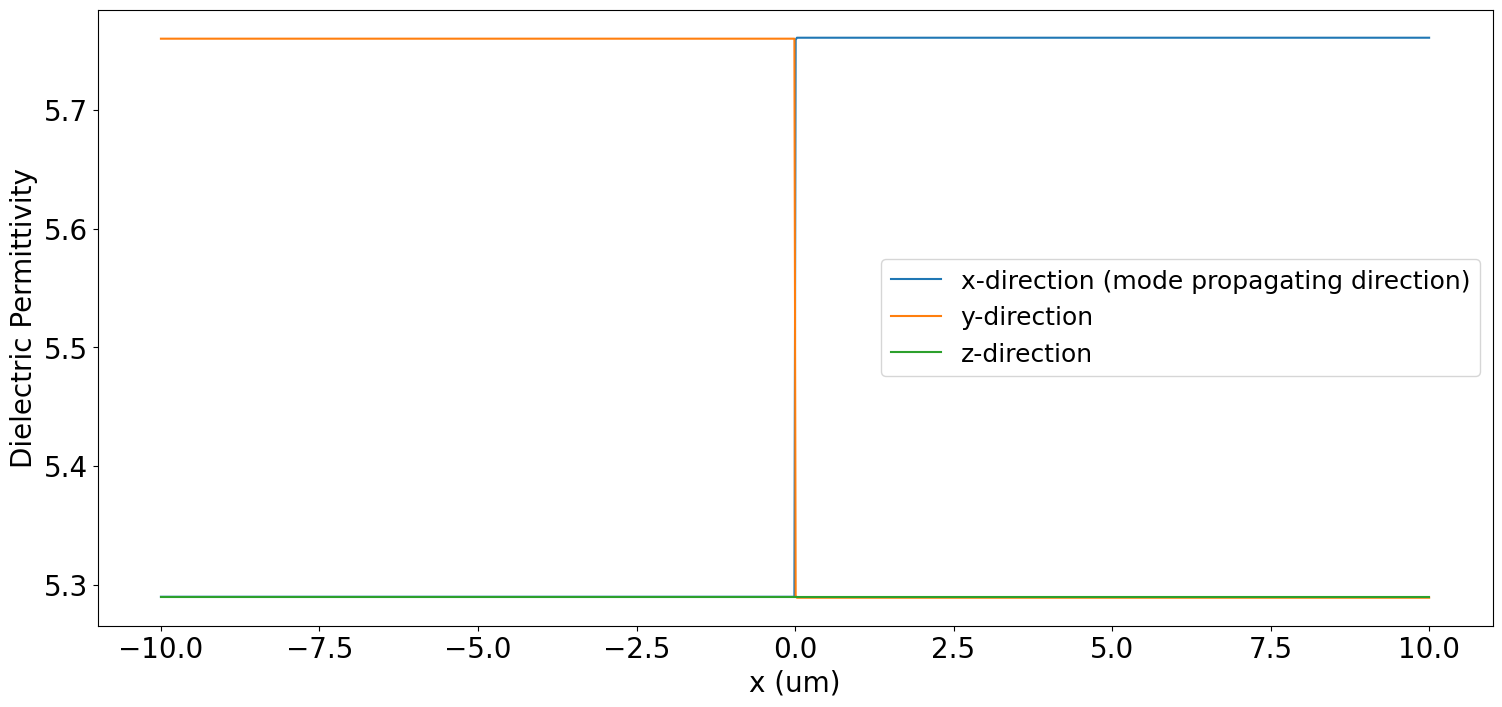

In [4]:
# Show the dielectric permittivity profile.

xx = np.linspace(-sim_length/2, sim_length/2, Nx)
plt.figure(figsize=(18, 8), dpi=100)  
plt.plot(xx, eps_data_x[:, 0, 0], label='x-direction (mode propagating direction)')
plt.plot(xx, eps_data_y[:, 0, 0], label='y-direction')
plt.plot(xx, eps_data_z[:, 0, 0], label='z-direction')
plt.xlabel('x (um)', fontsize=20)
plt.ylabel('Dielectric Permittivity', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)  # Increase tick number size
plt.legend(fontsize=18)


In [11]:
# Define the substrate and the waveguide. The waveguide is oriented along the x-axis, and the mode is injected along the positive x-axis.
#! Note that they both need to be extended into the PML layers.
#? So, it is best to extend the substrate and waveguide beyond the simulation domain size.

# Define the materials' permittivity.
#! BTO has an anisotropic electric permittivity.
# Only considered the diagonal elements.

mat_aniso_spatial_bto = td.CustomAnisotropicMedium(xx = mat_custom_x, yy = mat_custom_y, zz = mat_custom_z)

# mat_bto = td.AnisotropicMedium(
#     xx=td.Medium(permittivity=5.76),
#     yy=td.Medium(permittivity=5.76),
#     zz=td.Medium(permittivity=5.29),
#     name = 'bto'
# )

#! You have to define the mat_bto also as a custom medium to be able to use the spatially varying permittivity.
mat_bto = td.CustomAnisotropicMedium(xx = mat_custom_x_not_varying, yy = mat_custom_y_not_varying, zz = mat_custom_z_not_varying)

mat_sto = td.Medium(permittivity=sto_eps, name='sto')

mat_sio2 = td.Medium(permittivity=sio2_eps, name='sio2')

mat_si = td.Medium(permittivity=si_eps, name='silica')

#! Waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0,0,0],
        size=[td.inf, wg_width, wg_height], # Infinitely long waveguide but does not matter. Only care about the simulation length.
    ),
    medium=mat_bto,
    name='waveguide',
)
waveguide_vary = td.Structure(
    geometry=td.Box(
        center=[0,0,0],
        size=[td.inf, wg_width, wg_height], # Infinitely long waveguide but does not matter. Only care about the simulation length.
    ),
    medium=mat_aniso_spatial_bto,
    name='waveguide',
)

#! BTO substrate
bto_substrate = td.Structure(
    geometry=td.Box(
        center=[0,0,-(1/2)*(wg_height + bto_height)], #! Put the half of the sum of the heights of the waveguide and BTO substrate.
        size=[td.inf, td.inf, bto_height], # Infinitely long waveguide but does not matter. Only care about the simulation length.
    ),
    medium=mat_bto,
    name='bto_substrate',
)
bto_substrate_vary = td.Structure(
    geometry=td.Box(
        center=[0,0,-(1/2)*(wg_height + bto_height)], #! Put the half of the sum of the heights of the waveguide and BTO substrate.
        size=[td.inf, td.inf, bto_height], # Infinitely long waveguide but does not matter. Only care about the simulation length.
    ),
    medium=mat_aniso_spatial_bto,
    name='bto_substrate',
)

#! STO substrate
sto_substrate = td.Structure(
    geometry=td.Box(
        center=[0,0,-(1/2)*(wg_height+sto_height) - bto_height], #! Put the half of the sum of the heights of the waveguide and BTO substrate.
        size=[td.inf, td.inf, sto_height], # Infinitely long waveguide but does not matter. Only care about the simulation length.
    ),
    medium=mat_sto,
    name='sto_substrate',
)

#! SiO2 substrate
sio2_substrate = td.Structure(
    geometry=td.Box(
        center=[0,0,-(1/2)*(wg_height+ sio2_height) - bto_height - sto_height], #! Put the half of the sum of the heights of the waveguide and BTO substrate.
        size=[td.inf, td.inf, sio2_height], # Infinitely long waveguide but does not matter. Only care about the simulation length.
    ),
    medium=mat_sio2,
    name='sio2_substrate',
)

#! Si substrate
si_substrate = td.Structure(
    geometry=td.Box(
        center=[0,0,-(1/2)*(wg_height+ si_height) - bto_height - sto_height - sio2_height], #! Put the half of the sum of the heights of the waveguide and BTO substrate.
        size=[td.inf, td.inf, si_height], # Infinitely long waveguide but does not matter. Only care about the simulation length.
    ),
    medium=mat_si,
    name='si_substrate',
)


In [57]:
# Define the Field, Flux, and Mode monitors.


src_pos = -sim_size[0]/2 + spacing - 0.1  # position of the source
sz_plane = 2 # Monitor and modal plane size in um

#! Mode source to inject
mode_spec = td.ModeSpec(num_modes=2)  # number of modes to solve for
mode_source = td.ModeSource(
    center=[src_pos, 0, 0], # The center of modal source is the same as the center of the waveguide.
    size=[0, 2*sz_plane, 2*sz_plane], # Does size matter??
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0
)

mnt_list = []
# mode_mnt_list = []

#! xy-plane frequency-domain field monitor at central frequency
#? CHANGE THE POSITION OF THE MONITOR to [0, 0, 0]
freq_mnt = td.FieldMonitor(
    center = [0, 0, 0],  #! Same as the center of the waveguide.
    size = [np.inf, np.inf, 0],
    freqs=[freq0],
    name='field')
mnt_list.append(freq_mnt)

#! A series of flux monitors
offset_from_source = 0.05 # a space between the first monitor and the source
pos_start = src_pos + offset_from_source # define the position of the monitor
pos_end = sim_size[0]/2 - spacing


# ############################################################################################################
#? CHANGE THE NUMBER OF MONITORS
# ############################################################################################################

num = 2

# ############################################################################################################
# ############################################################################################################

pos_list = np.linspace(pos_start, pos_end, num)
#! Flux monitors
for i in range(num):
    flux_mnt = td.FluxMonitor(
        center = [pos_list[i], 0.0, 0.0],
        size = [0, sz_plane, sz_plane],
        freqs = [freq0],
        name = "flux" + str(i)
    )
    mnt_list.append(flux_mnt)
    
#! Mode monitors
for i in range(num):
    mode_mnt = td.ModeMonitor(
        center = [pos_list[i], 0.0, 0.0],
        size = [0, sz_plane, sz_plane],
        freqs = [freq0],
        mode_spec = mode_spec,
        name = "mode" + str(i)
    )
    mnt_list.append(mode_mnt)


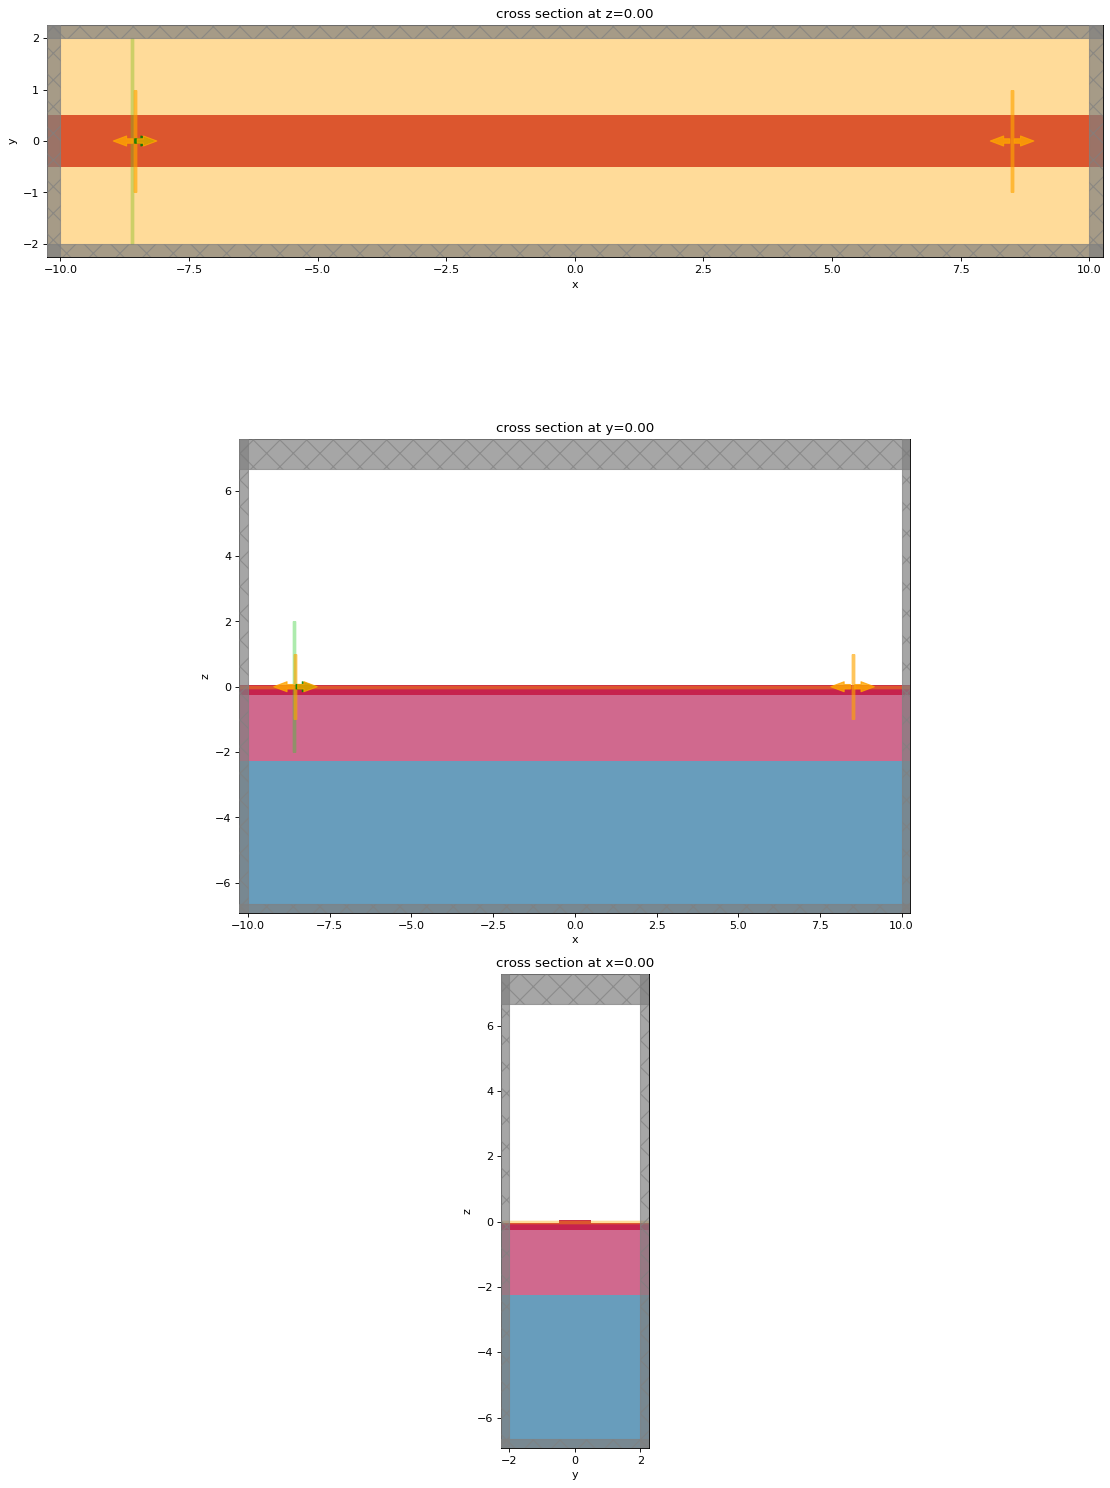

In [58]:
# Define the simulations
sim_spatially_varying = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[si_substrate, sio2_substrate, sto_substrate, bto_substrate_vary, waveguide_vary],
    sources=[mode_source],
    monitors=mnt_list,
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())) #! Using PML boundary condition. Can be vary.

sim_unperturbed = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[si_substrate, sio2_substrate, sto_substrate, bto_substrate, waveguide],
    sources=[mode_source],
    monitors=mnt_list,
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())) #! Using PML boundary condition. Can be vary.

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, tight_layout=True, dpi=80, figsize=(14, 20))
sim_spatially_varying.plot(z=0, ax=ax1)
sim_spatially_varying.plot(y=0, ax=ax2)
sim_spatially_varying.plot(x=0, ax=ax3)

plt.show()

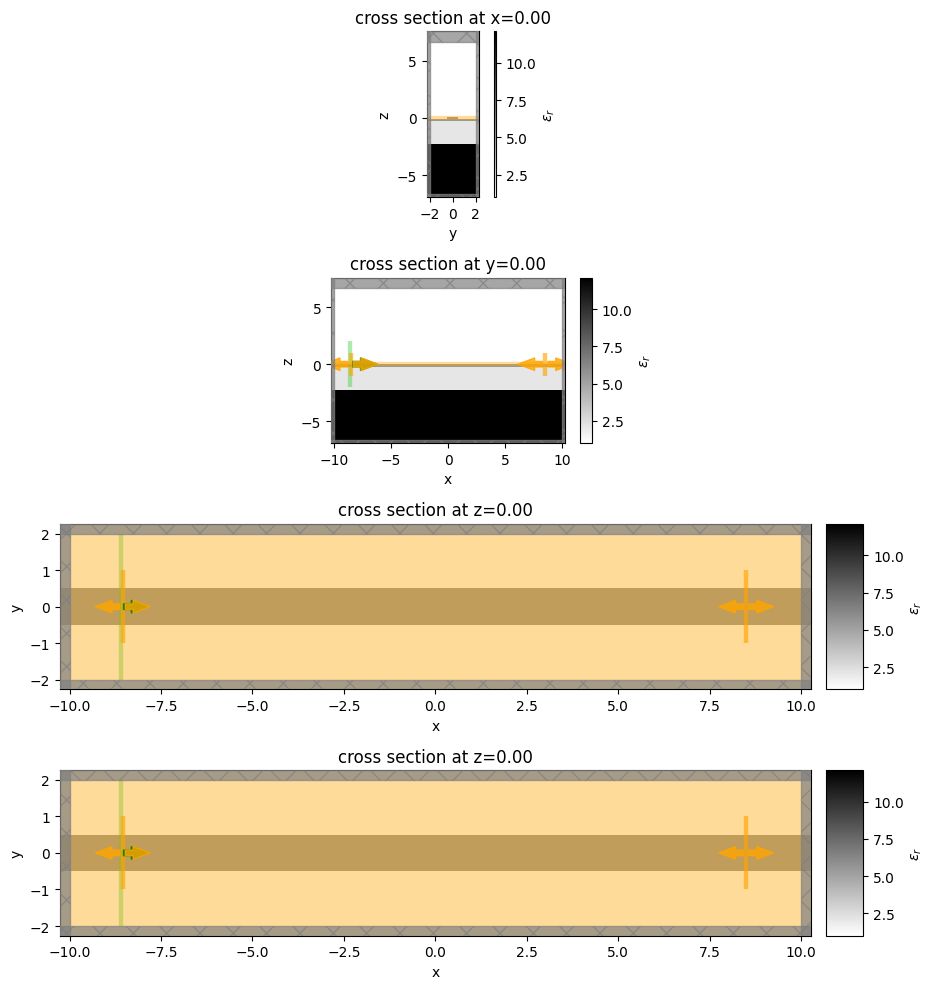

In [59]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, tight_layout=True, dpi=100, figsize=(14, 10))
sim_spatially_varying.plot_eps(x=0, ax=ax1)
sim_spatially_varying.plot_eps(y=0, ax=ax2)
sim_spatially_varying.plot_eps(z=0, ax=ax3)
sim_spatially_varying.plot_eps(z=0, ax=ax4)
plt.show()

In [60]:
sim_spatially_varying.plot_3d()

In [10]:
# Setup the source

# src_plane = td.Box(center=[src_pos, 0, 0], size=[0, sz_plane, sz_plane])
src_plane = td.Box(center=[src_pos, 0, 0], size=[0, 2*sz_plane, 2*sz_plane])


# number of modes to compute
num_modes = 2

# setup and solve for modes
mode_spec = td.ModeSpec(num_modes=num_modes)

ms_spatially_varying = ModeSolver(simulation=sim_spatially_varying, plane=src_plane, mode_spec=mode_spec, freqs=[freq0])
ms_unperturbed = ModeSolver(simulation=sim_unperturbed, plane=src_plane, mode_spec=mode_spec, freqs=[freq0])

modes_spatially_varying = ms_spatially_varying.solve()
modes_unperturbed = ms_unperturbed.solve()

#! Because of the grid that is defined differently, the effective index is different. But it should be the same.
print("Effective index of computed modes:", np.array(modes_spatially_varying.n_eff))
print("Effective index of computed modes:", np.array(modes_unperturbed.n_eff))


23:51:21 중부 일광 절약 시간 WARNING: Use the remote mode solver with subpixel  
                             averaging for better accuracy through              
                             'tidy3d.plugins.mode.web.run(...)'.                

23:51:22 중부 일광 절약 시간 WARNING: Mode field at frequency index 0, mode     
                             index 1 does not decay at the plane boundaries.    

                     WARNING: Mode field at frequency index 0, mode index 1 does
                     not decay at the plane boundaries.                         

Effective index of computed modes: [[1.9407095 1.8237357]]
Effective index of computed modes: [[1.9434015 1.8281184]]


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  1.899032    0.0          0.995120   
             1                 1.55  1.774111    0.0          0.991168   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.963292        0.811421   0.634788  
             1                 0.946656        0.803093   0.776372

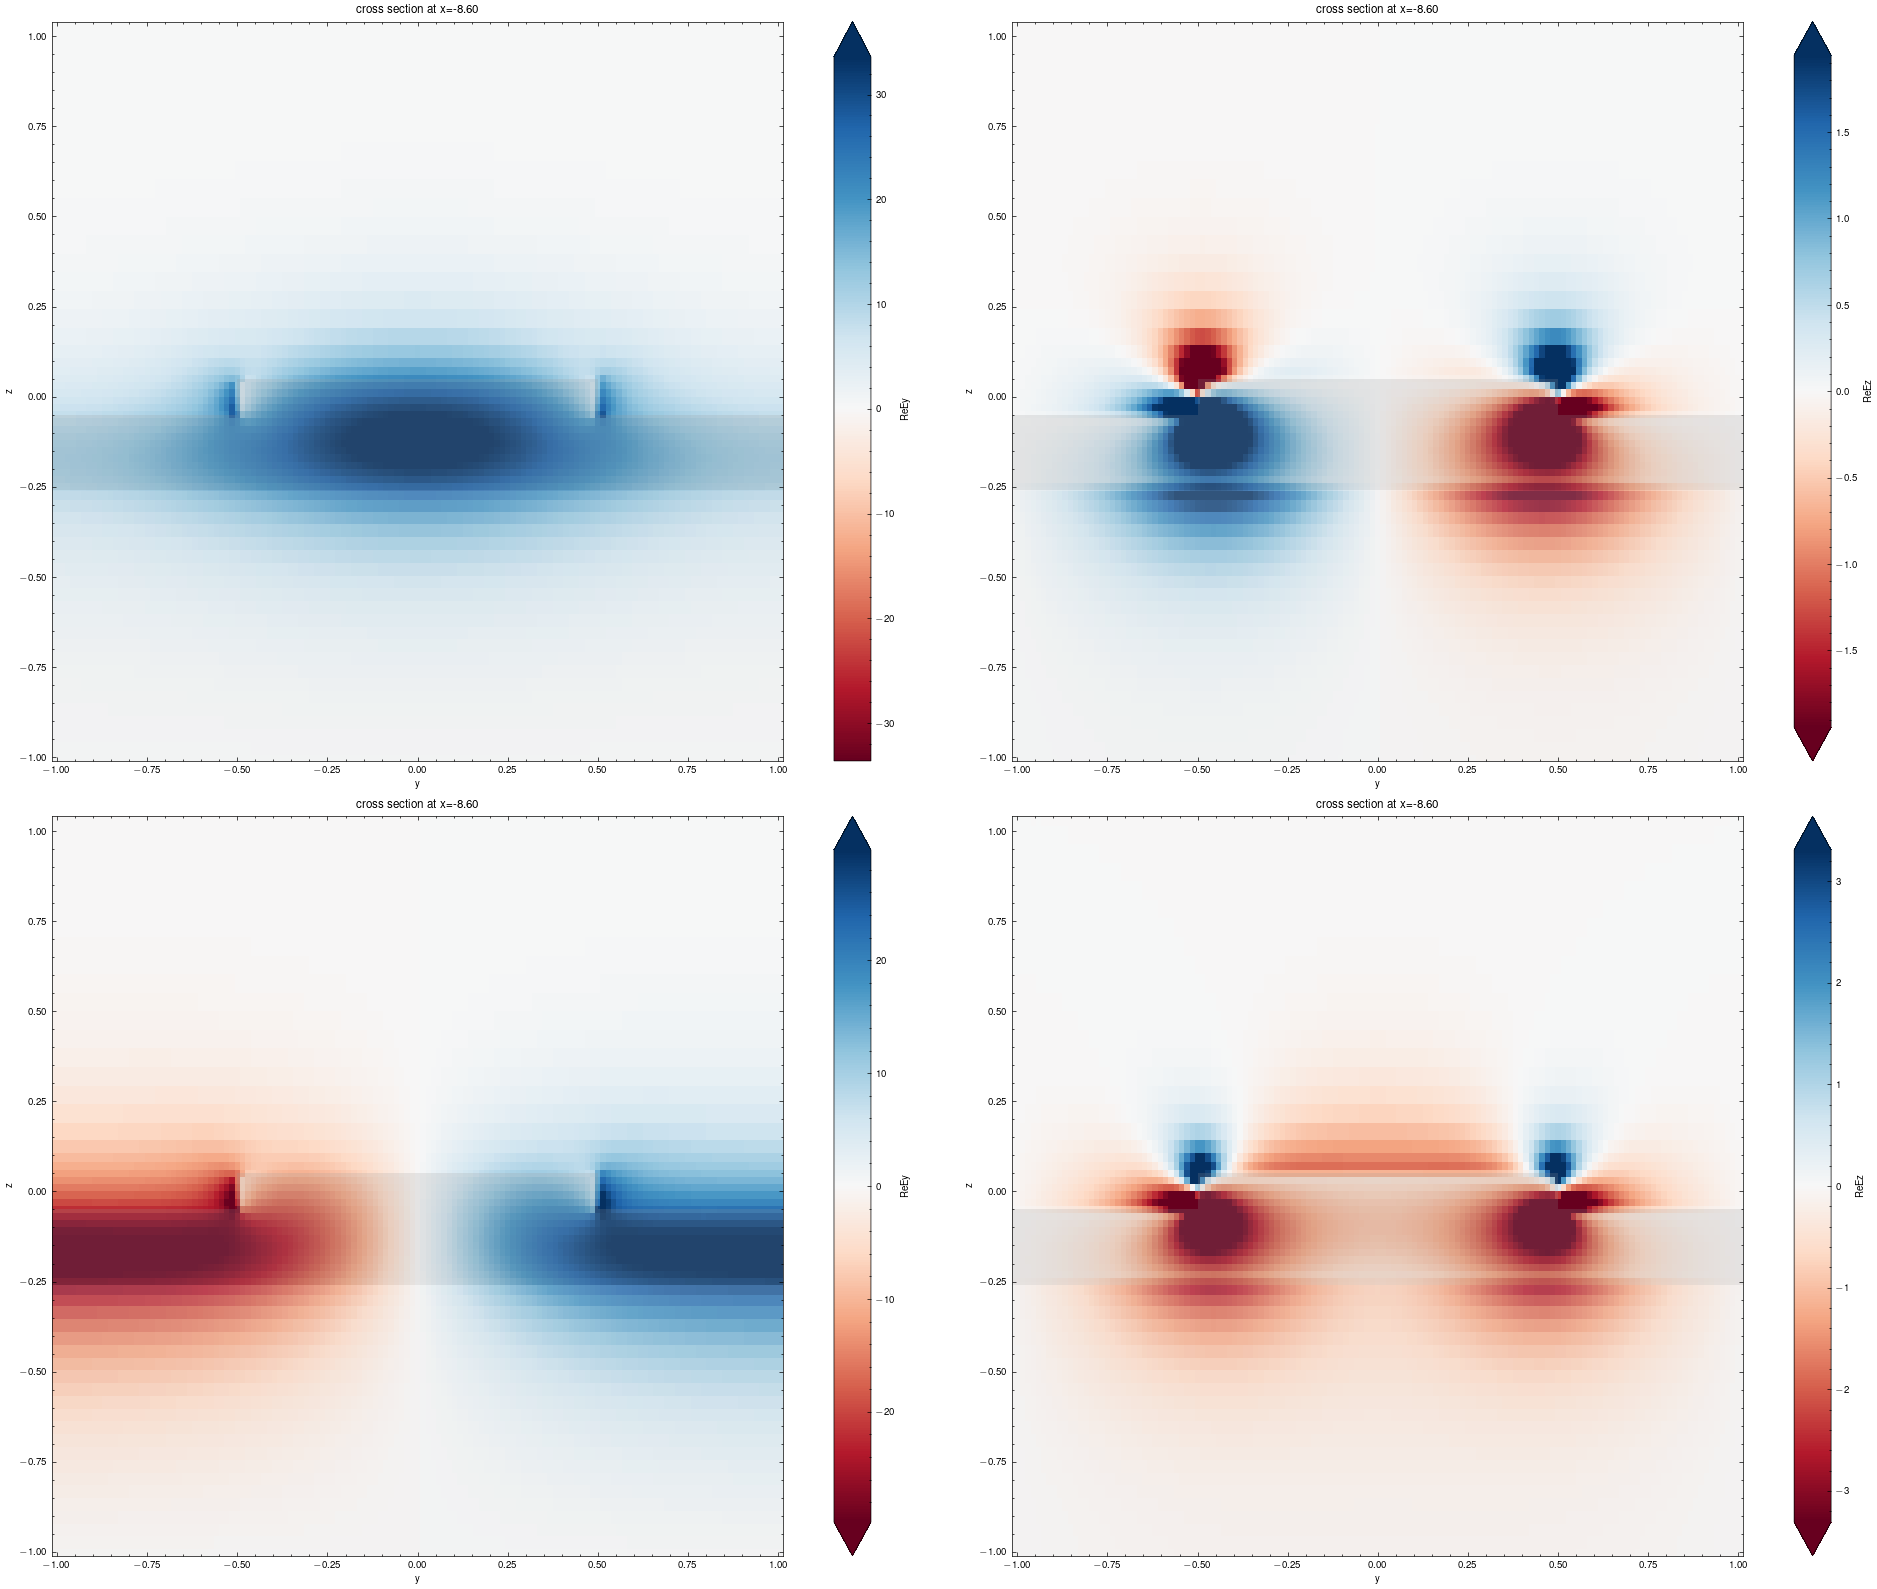

In [254]:
fig, axs = plt.subplots(num_modes, 2, dpi = 100, figsize=(20, 16), tight_layout=True)
for mode_ind in range(num_modes):
    ms_spatially_varying.plot_field("Ey", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    ms_spatially_varying.plot_field("Ez", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])
# plt.show()
modes_spatially_varying.to_dataframe()

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  1.930034    0.0          0.995703   
             1                 1.55  1.814077    0.0          0.990424   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.966949         0.81770   0.621839  
             1                 0.953402         0.80776   0.769082

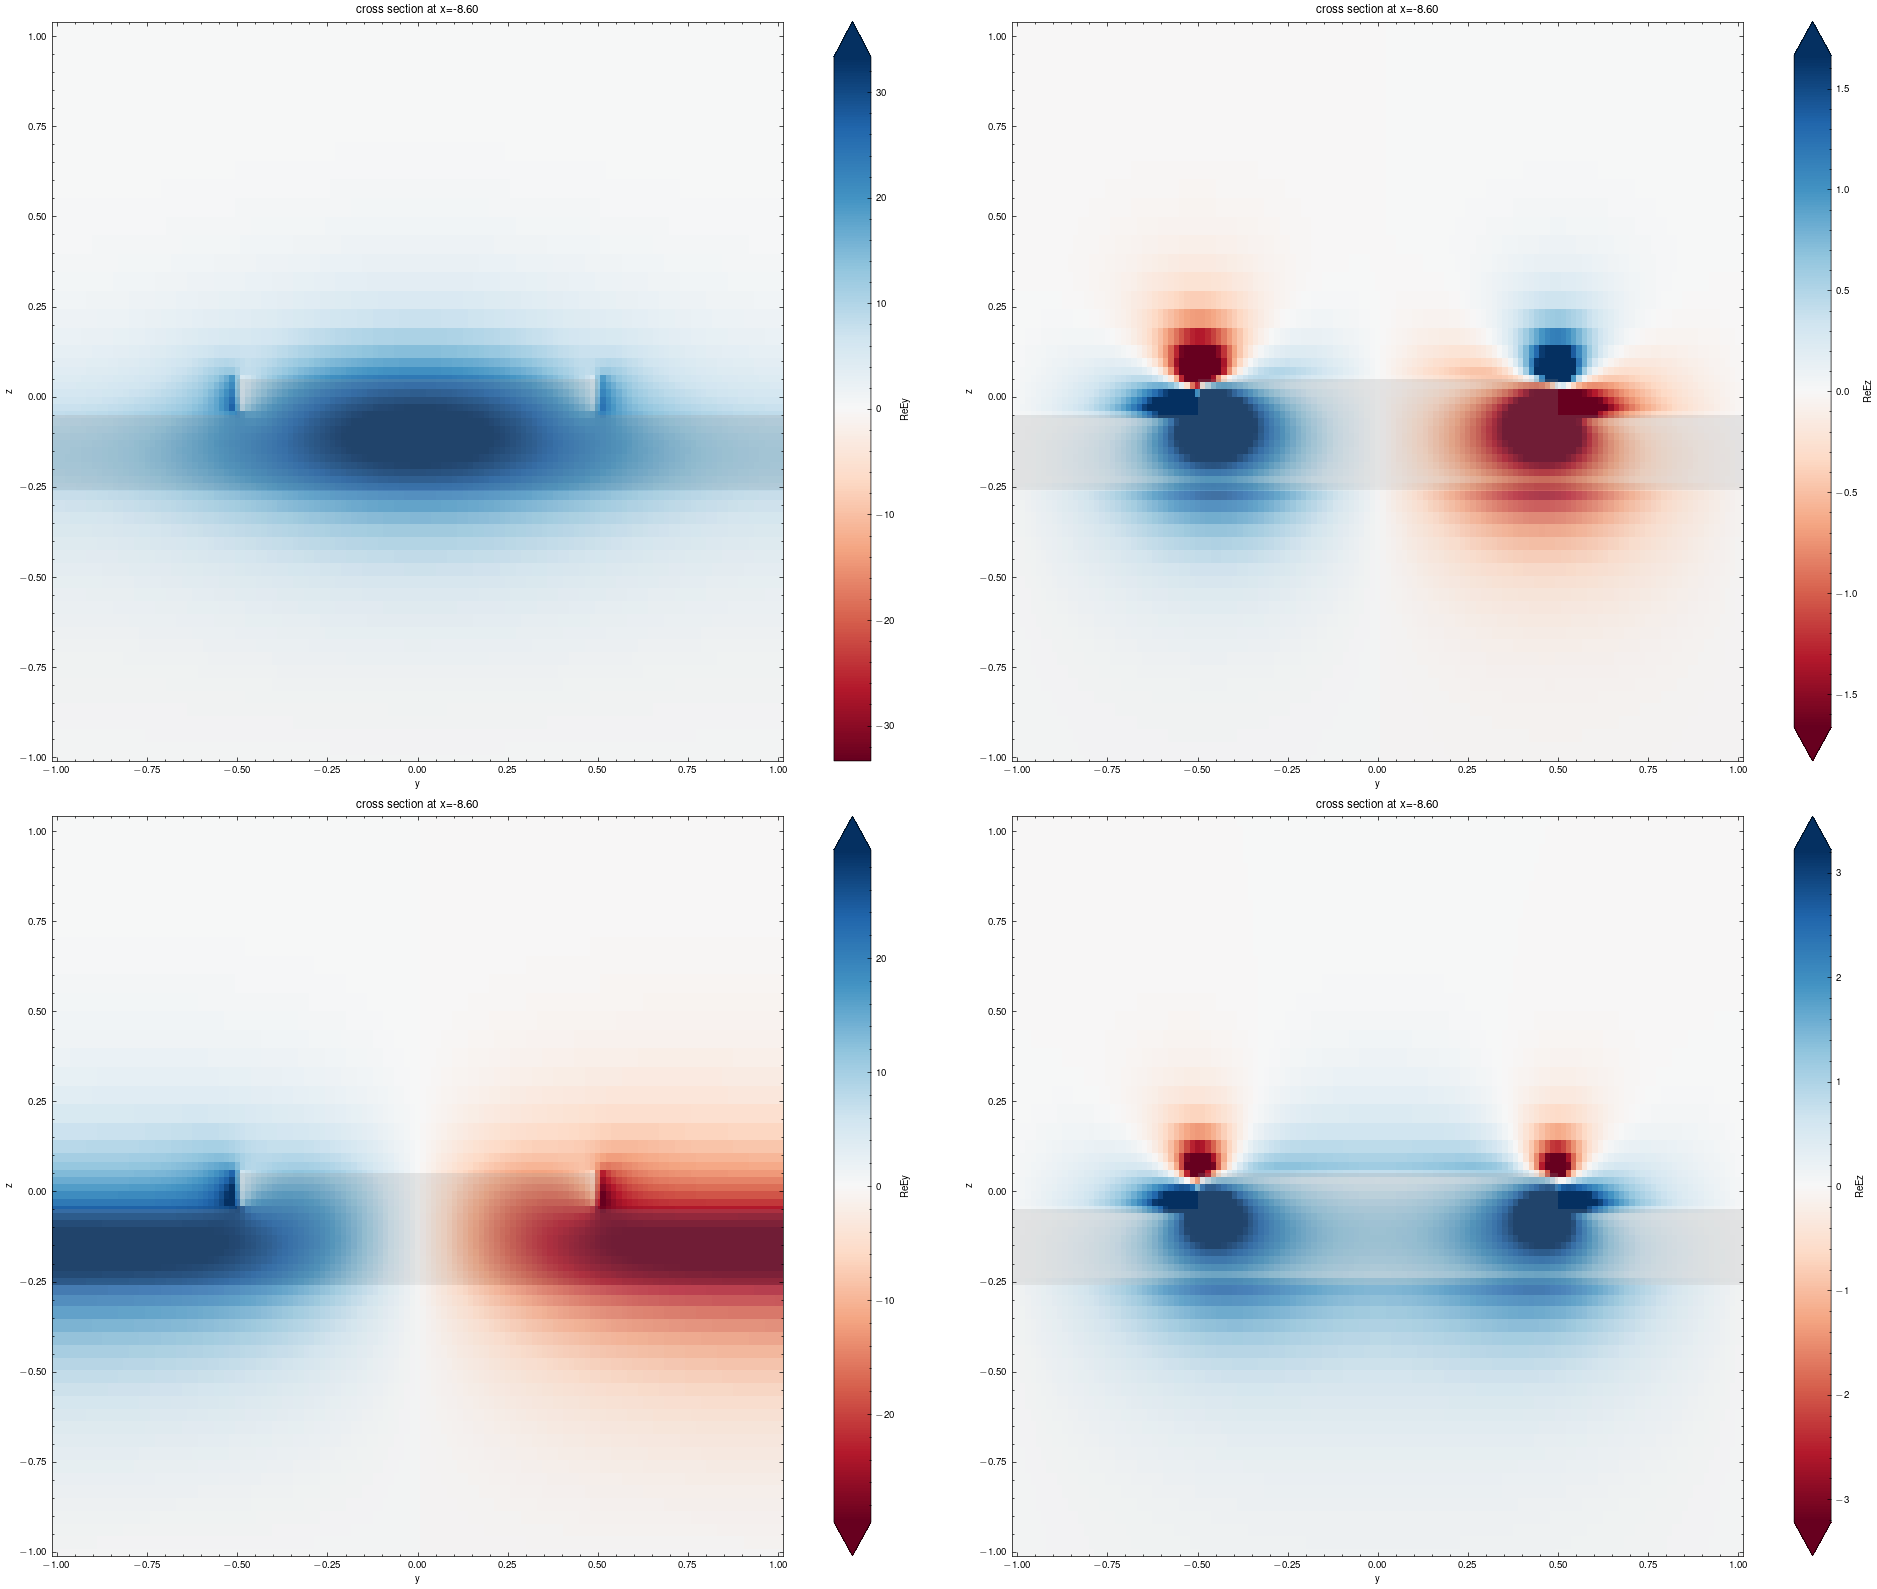

In [255]:
fig, axs = plt.subplots(num_modes, 2, dpi = 100, figsize=(20, 16), tight_layout=True)
for mode_ind in range(num_modes):
    ms_unperturbed.plot_field("Ey", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    ms_unperturbed.plot_field("Ez", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])
# plt.show()
modes_unperturbed.to_dataframe()

In [256]:
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)


mode_spatially_varying = ms_spatially_varying.to_source(mode_index=0, direction="+", source_time=source_time)  # change the mode index to excite different modes. 0 = fundamental TE mode.
mode_unperturbed = ms_unperturbed.to_source(mode_index=0, direction="+", source_time=source_time)  # change the mode index to excite different modes. 0 = fundamental TE mode.


#! Defining the source to inject to the simulation.
sim_spatially_varying = sim_spatially_varying.copy(update={'sources':[mode_spatially_varying]})
# sim_spatially_varying_unperturbed_source = sim_spatially_varying_unperturbed_source.copy(update={'sources':[mode_unperturbed]})
sim_unperturbed = sim_unperturbed.copy(update={'sources':[mode_unperturbed]})

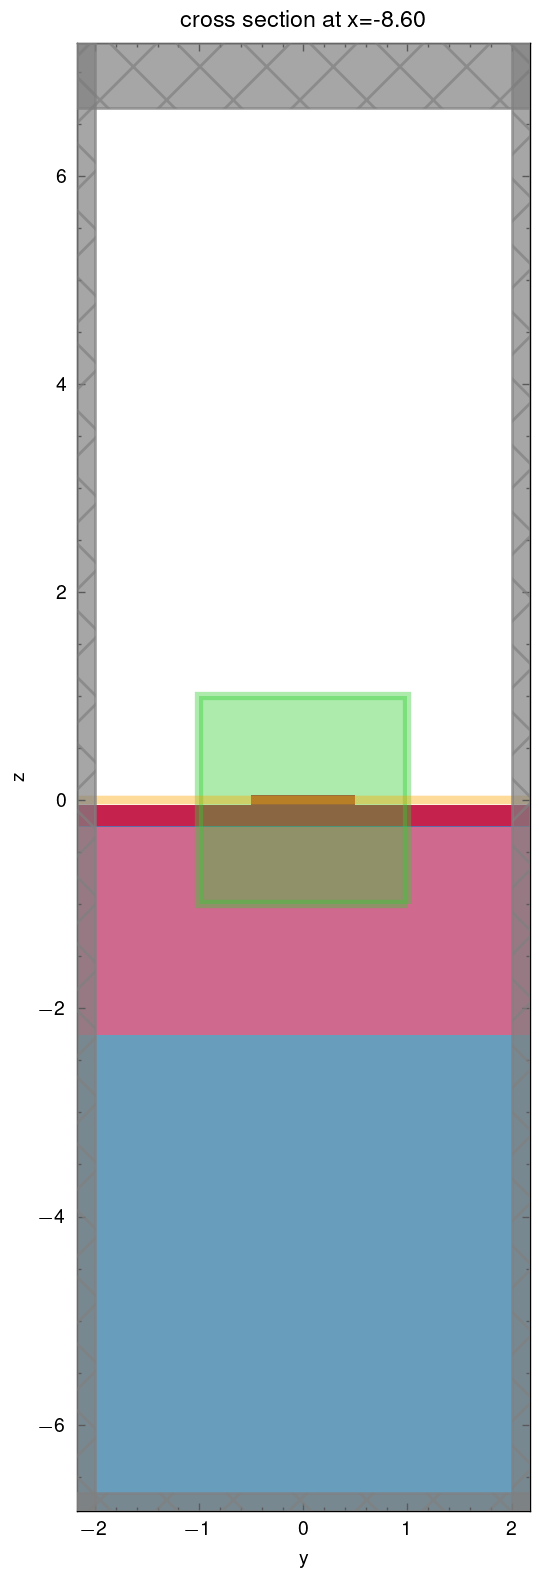

In [257]:
fig, ax = plt.subplots(1, dpi = 200, tight_layout=True, figsize=(4, 8))
sim_spatially_varying.plot(x=src_pos, ax=ax)
plt.show()

In [61]:
# Run the simulations

sim_data = web.run(sim_spatially_varying, task_name='bto_waveguide_spacial_varying_perturbed_source', path=f'data/90_DW/data_mode.hdf5')
sim_unperturbed_data = web.run(sim_unperturbed, task_name='bto_waveguide_unperturbed_source_test', path=f'data/No_DW/data_mode.hdf5')

00:38:14 중부 일광 절약 시간 Created task                                       
                             'bto_waveguide_spacial_varying_perturbed_source'   
                             with task_id                                       
                             'fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e' and    
                             task_type 'FDTD'.

                     View task using web UI at                                  
                     ]8;id=794069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=311261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\taskId]8;;\]8;id=794069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\=]8;;\]8;id=812706;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\fdve]8;;\]8;id=794069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\-fe3b]8;;\
                     ]8;id=794069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\4c82-6c2a-4018-ad48-193564d31b6e']8;;\.

c:\Users\14087\Documents\GitHub\dft\.conda\lib\site-packages\rich\live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

00:38:16 중부 일광 절약 시간 status = queued

00:38:20 중부 일광 절약 시간 status = preprocess

00:38:25 중부 일광 절약 시간 Maximum FlexCredit cost: 2.361. Use                
                             'web.real_cost(task_id)' to get the billed         
                             FlexCredit cost after a simulation run.

                     starting up solver

                     running solver

                     To cancel the simulation, use 'web.abort(task_id)' or      
                     'web.delete(task_id)' or abort/delete the task in the web  
                     UI. Terminating the Python script will not stop the job    
                     running on the cloud.

00:39:40 중부 일광 절약 시간 early shutoff detected at 8%, exiting.

                     status = postprocess

00:39:48 중부 일광 절약 시간 status = success

                     View simulation result at                                  
                     ]8;id=251844;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=833806;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\taskId]8;;\]8;id=251844;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\=]8;;\]8;id=95503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\fdve]8;;\]8;id=251844;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\-fe3b]8;;\
                     ]8;id=251844;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe3b4c82-6c2a-4018-ad48-193564d31b6e\4c82-6c2a-4018-ad48-193564d31b6e']8;;\.

00:40:00 중부 일광 절약 시간 loading simulation from data/90_DW/data_mode.hdf5

                     Created task 'bto_waveguide_unperturbed_source_test' with  
                     task_id 'fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b' and    
                     task_type 'FDTD'.

                     View task using web UI at                                  
                     ]8;id=791161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=215261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\taskId]8;;\]8;id=791161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\=]8;;\]8;id=581863;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\fdve]8;;\]8;id=791161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\-42e5]8;;\
                     ]8;id=791161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\2ab4-d106-4709-9ba4-6a0bb042084b']8;;\.

c:\Users\14087\Documents\GitHub\dft\.conda\lib\site-packages\rich\live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

00:40:02 중부 일광 절약 시간 status = queued

00:40:06 중부 일광 절약 시간 status = preprocess

00:40:11 중부 일광 절약 시간 Maximum FlexCredit cost: 2.361. Use                
                             'web.real_cost(task_id)' to get the billed         
                             FlexCredit cost after a simulation run.

                     starting up solver

                     running solver

                     To cancel the simulation, use 'web.abort(task_id)' or      
                     'web.delete(task_id)' or abort/delete the task in the web  
                     UI. Terminating the Python script will not stop the job    
                     running on the cloud.

00:41:25 중부 일광 절약 시간 early shutoff detected at 8%, exiting.

                     status = postprocess

00:41:32 중부 일광 절약 시간 status = success

00:41:33 중부 일광 절약 시간 View simulation result at                          
                             ]8;id=253425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=879782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\taskId]8;;\]8;id=253425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\=]8;;\]8;id=237452;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\f]8;;\
                             ]8;id=237452;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\dve]8;;\]8;id=253425;https://tidy3d.simulation.cloud/workbench?taskId=fdve-42e52ab4-d106-4709-9ba4-6a0bb042084b\-42e52ab4-d106-4709-9ba4-6a0bb042084b']8;;\.

00:41:35 중부 일광 절약 시간 loading simulation from data/No_DW/data_mode.hdf5

c:\Users\14087\Documents\GitHub\dft\.conda\lib\site-packages\xarray\core\computation.py:822: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


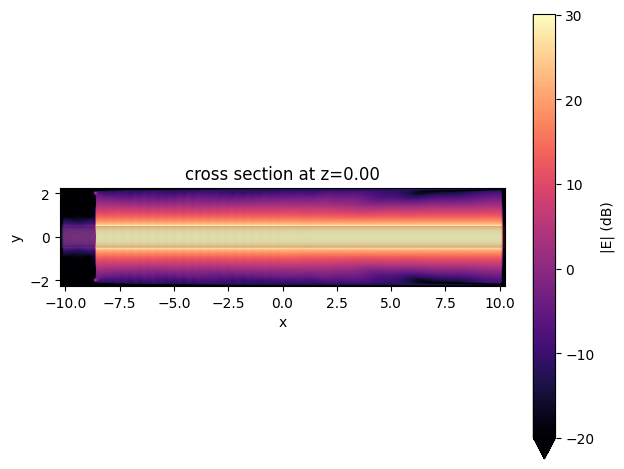

c:\Users\14087\Documents\GitHub\dft\.conda\lib\site-packages\xarray\core\computation.py:822: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


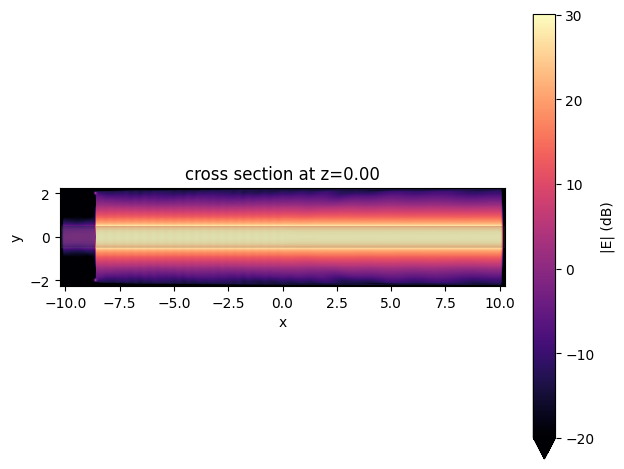

In [56]:
sim_data.plot_field(
    field_monitor_name="field",
    field_name="E",
    val="abs",
    scale="dB",
    vmin=-20,
    vmax=30,
)
plt.show()

sim_unperturbed_data.plot_field(
    field_monitor_name="field",
    field_name="E",
    val="abs",
    scale="dB",
    vmin=-20,
    vmax=30,
)
plt.show()

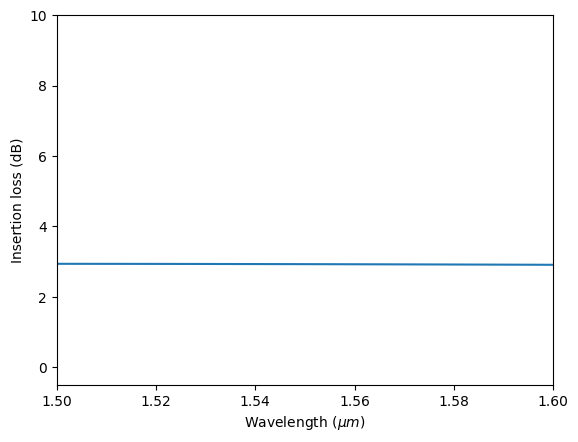

In [64]:
# extract the transmission data from the mode monitor
amp = sim_data["mode1"].amps.sel(mode_index=0, direction="+")
T = np.abs(amp) ** 2 # transmission to the top waveguide
T_total = 2 * T # total transmission at the two output waveguides

plt.plot(ldas, 10 * np.log10(T_total))
plt.xlim(1.5, 1.6)
plt.ylim(-0.5, 10)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Insertion loss (dB)")
plt.show()

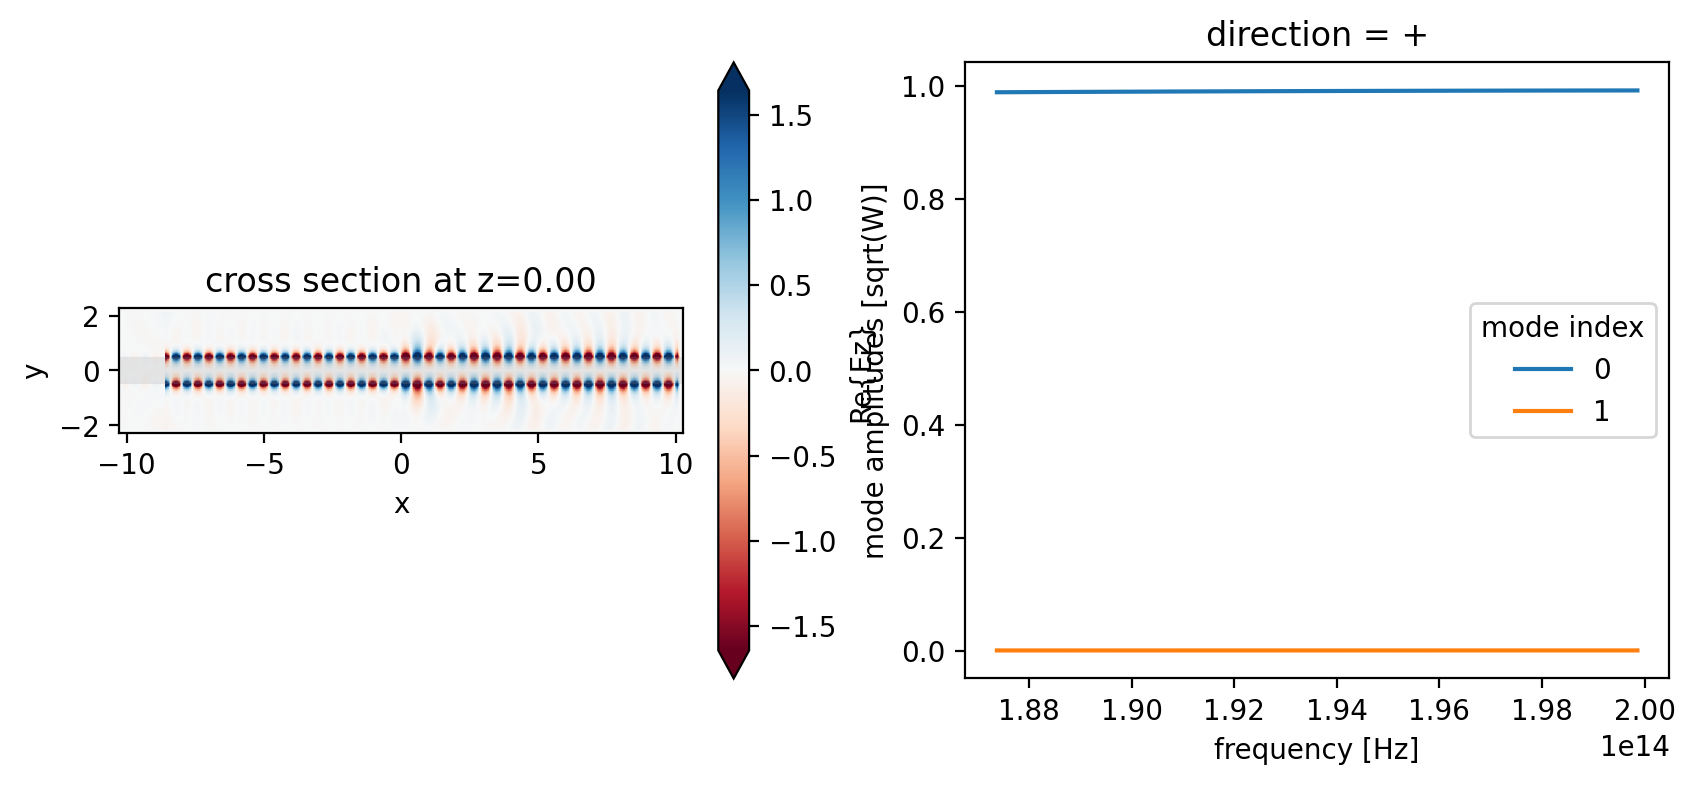

In [81]:
fig, ax = plt.subplots(1, 2, dpi=200, figsize=(10, 4))
sim_data.plot_field("field", "Ez", f=freq0, ax=ax[0])
sim_data["mode1"].amps.sel(direction="+").abs.plot.line(x="f", ax=ax[1])
plt.show()

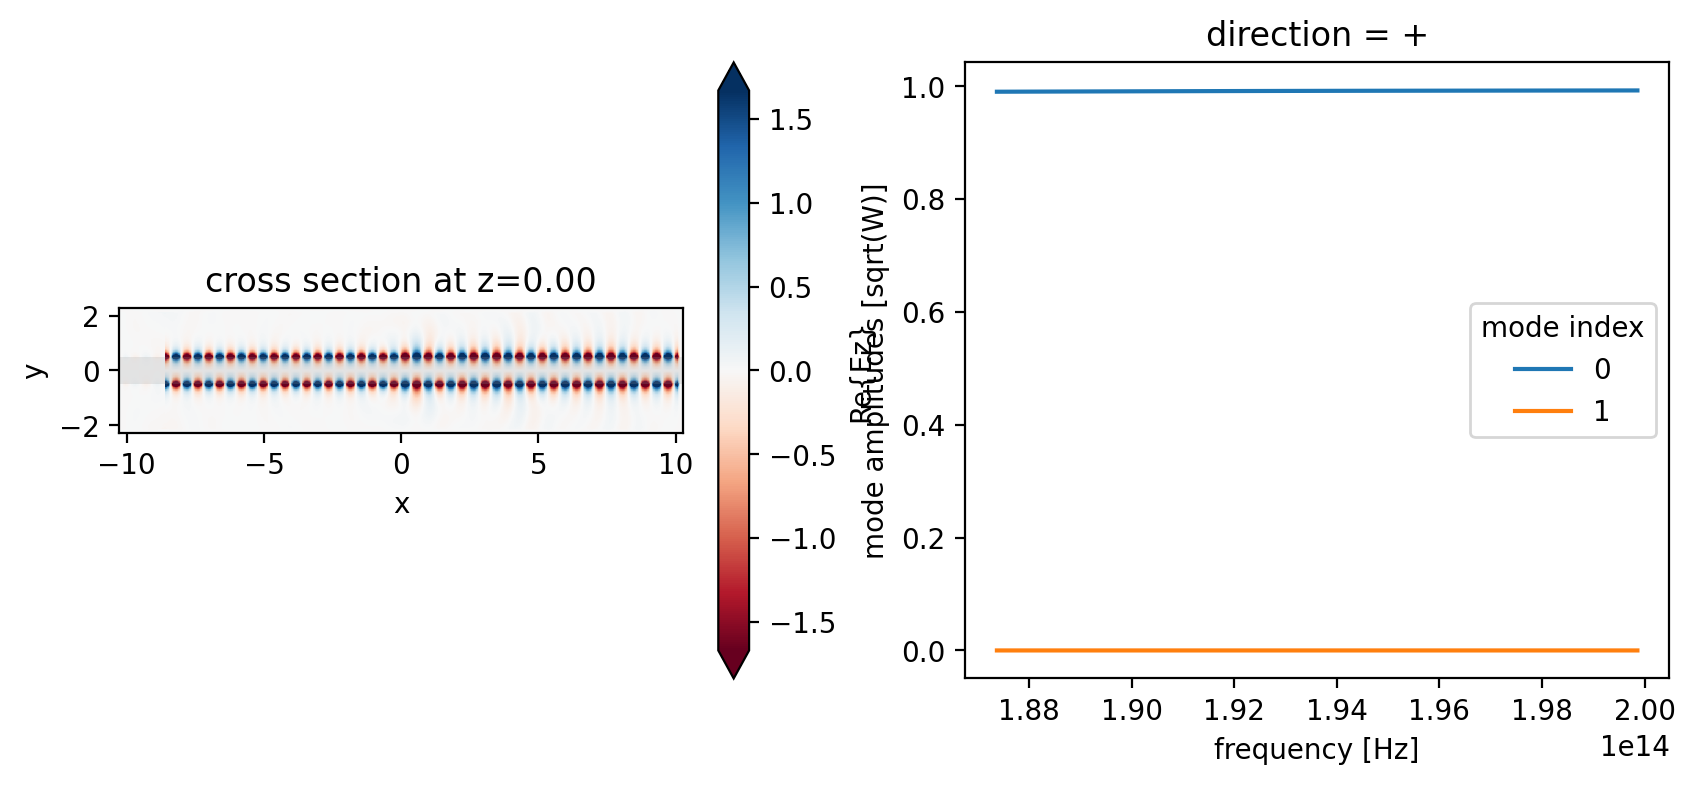

In [78]:
fig, ax = plt.subplots(1, 2, dpi=200,figsize=(10, 4))
sim_unperturbed_data.plot_field("field", "Ez", f=freq0, ax=ax[0])
sim_unperturbed_data["mode0"].amps.sel(direction="+").abs.plot.line(x="f", ax=ax[1])
plt.show()

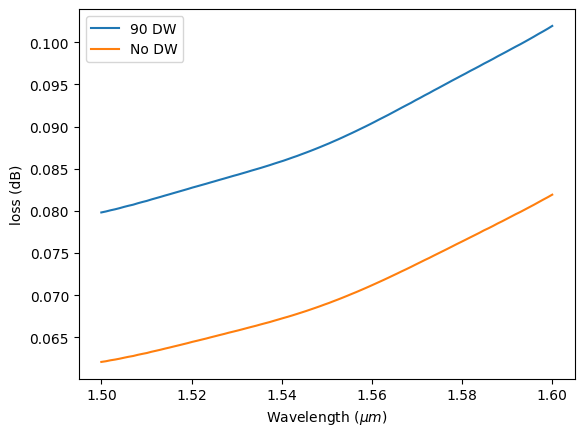

In [113]:
amp_1 = sim_data["mode0"].amps.sel(mode_index=0, direction="+")
amp_2 = sim_unperturbed_data["mode0"].amps.sel(mode_index=0, direction="+")

dw_90 = np.abs(amp_1)**2
no_dw = np.abs(amp_2)**2


plt.plot(ldas, -10 * np.log10(dw_90), label="90 DW")
plt.plot(ldas, -10 * np.log10(no_dw), label="No DW")

# plt.xlim(1.5, 1.6)
# plt.ylim(0, 0.03)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("loss (dB)")
plt.legend()
plt.show()

In [117]:
########################################################################################
#! Calculating the loss in waveguide. Only at the 1.55 um wavelength.
########################################################################################

flux_list = np.zeros_like(pos_list)
flux_unperturbed_list = np.zeros_like(pos_list)
for i in range(num):
    flux_list[i] = sim_data['flux'+str(i)].flux
    flux_unperturbed_list[i] = sim_unperturbed_data['flux'+str(i)].flux

print("The loss is", -10*np.log10(flux_list[0]/flux_list[-1])/((pos_list - src_pos)[-1] - (pos_list - src_pos)[0])*(10**(4)), "dB/cm")
print("The loss is", -10*np.log10(flux_unperturbed_list[0]/flux_unperturbed_list[-1])/((pos_list - src_pos)[-1] - (pos_list - src_pos)[0])*(10**(4)), "dB/cm")
print("The length of the propagation of the waveguide is", (pos_list - src_pos)[-1] - (pos_list - src_pos)[0], "um")
print(flux_list[0]/flux_list[-1])
print(flux_unperturbed_list[0]/flux_unperturbed_list[-1])

The loss is 2.518587559585144 dB/cm
The loss is -5.191834149812143 dB/cm
The length of the propagation of the waveguide is 17.05 um
0.9990117144761304
1.002040344782549


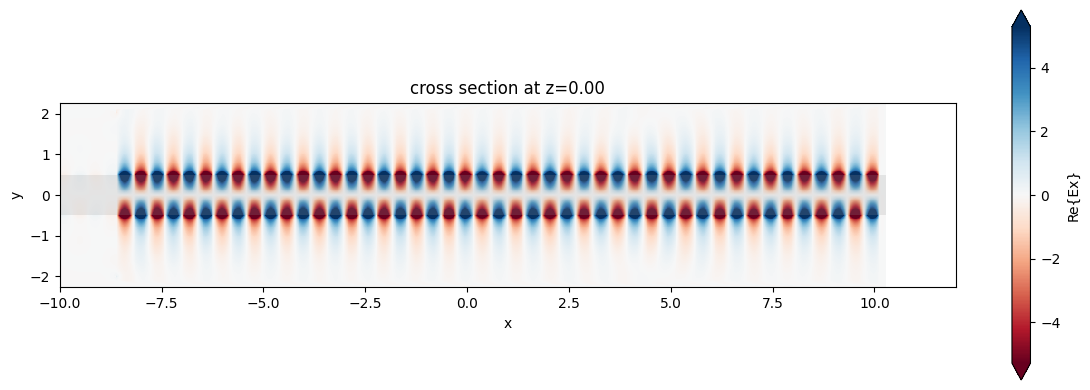

In [93]:
fig, ax = plt.subplots(1,figsize=(12, 4), dpi=100, tight_layout=True)
sim_data.plot_field('field', 'Ex', z=0, f=freq0, val='real', ax=ax)
ax.set_xlim([-10,12])
plt.show()

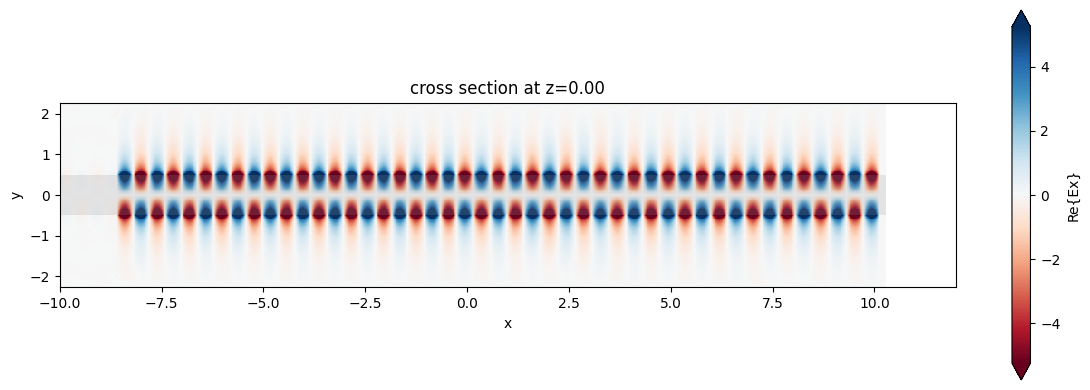

In [94]:
fig, ax = plt.subplots(1,figsize=(12, 4), dpi=100, tight_layout=True)

sim_unperturbed_data.plot_field('field', 'Ex', z=0, f=freq0, val='real', ax=ax)
ax.set_xlim([-10,12])

plt.show()

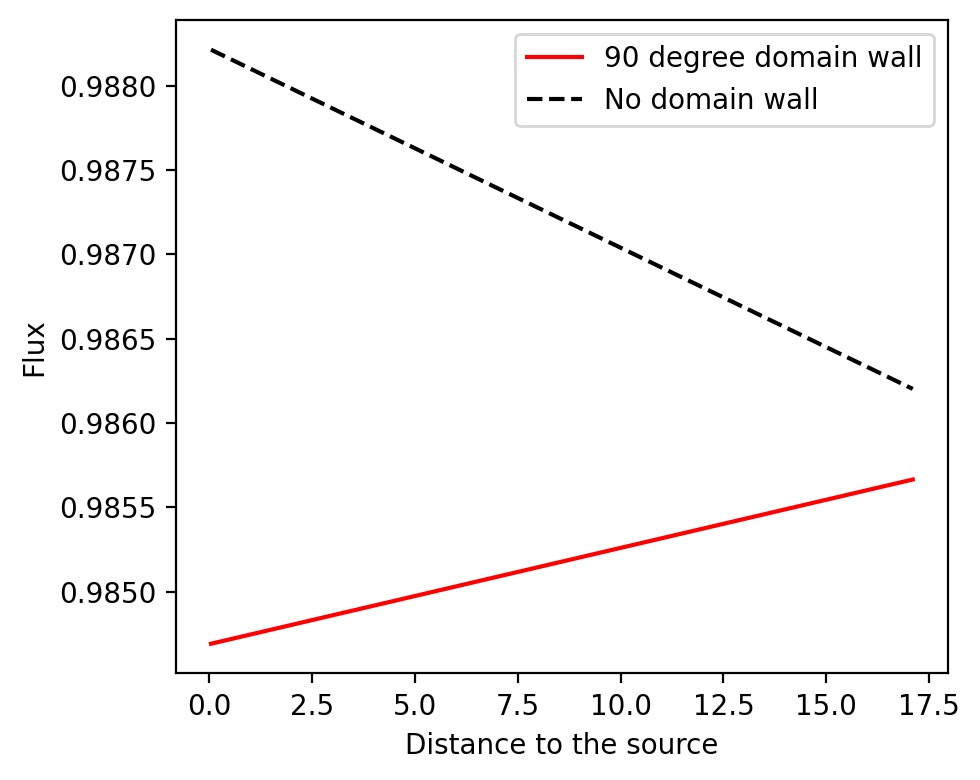

In [92]:
flux_list = np.zeros_like(pos_list)
flux_unperturbed_source_list = np.zeros_like(pos_list)
for i in range(num):
    flux_list[i] = sim_data['flux'+str(i)].flux
    flux_unperturbed_source_list[i] = sim_unperturbed_data['flux'+str(i)].flux

# TODO: Do this analysis in the spatial dependent dielectric permittivity case.
# normalize the dipole one
# flux_point_list /= flux_point_list[0]

fig, ax = plt.subplots(1,figsize=(5, 4), dpi=200, tight_layout=True)
ax.plot(pos_list - src_pos, flux_list, '-r',label='90 degree domain wall')
ax.plot(pos_list - src_pos, flux_unperturbed_source_list, '--k',label='No domain wall')
ax.set_xlabel('Distance to the source')
ax.set_ylabel('Flux')
ax.legend()
ax.ylimit = [0, 1]
plt.show()

In [80]:
sim_data

SimulationData(simulation=Simulation(type='Simulation', center=(0.0, 0.0, 0.0), size=(20.0, 4.0, 13.31), medium=Medium(name=None, frequency_range=None, allow_gain=False, nonlinear_spec=None, modulation_spec=None, heat_spec=None, type='Medium', permittivity=1.0, conductivity=0.0), structures=(Structure(geometry=Box(type='Box', center=(0.0, 0.0, -6.26), size=(inf, inf, 8.0)), name='si_substrate', type='Structure', medium=Medium(name='silica', frequency_range=None, allow_gain=False, nonlinear_spec=None, modulation_spec=None, heat_spec=None, type='Medium', permittivity=12.1104, conductivity=0.0)), Structure(geometry=Box(type='Box', center=(0.0, 0.0, -1.26), size=(inf, inf, 2.0)), name='sio2_substrate', type='Structure', medium=Medium(name='sio2', frequency_range=None, allow_gain=False, nonlinear_spec=None, modulation_spec=None, heat_spec=None, type='Medium', permittivity=2.1025, conductivity=0.0)), Structure(geometry=Box(type='Box', center=(0.0, 0.0, -0.255), size=(inf, inf, 0.01)), name='

The loss is 2.5185875595851442e-08 dB/cm
The length of the waveguide is 17.05 um


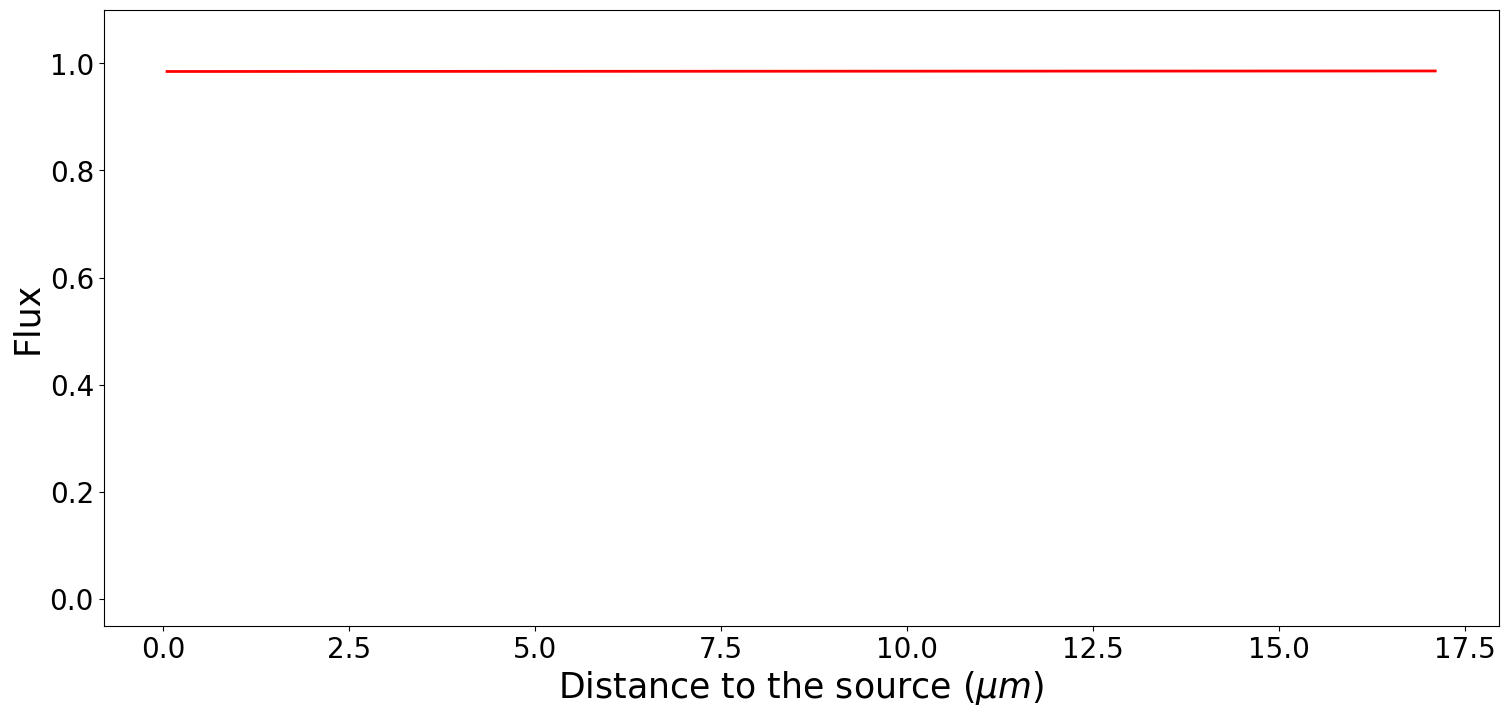

In [43]:
plt.figure(figsize=(18, 8), dpi=100)  
plt.plot(pos_list - src_pos, flux_list, '-r',label='Modal source', linewidth=2)
plt.ylim([-0.05, 1.1])
plt.xlabel(r'Distance to the source $(\mu m)$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)  # Increase tick number size
plt.ylabel('Flux', fontsize=25)
# plt.savefig('infi.png', dpi=200, format='png', bbox_inches='tight')  # Save the figure
print("The loss is", -10*np.log10(flux_list[0]/flux_list[-1])/((pos_list - src_pos)[-1] - (pos_list - src_pos)[0])*(10**(4)), "dB/cm")
print("The length of the waveguide is", (pos_list - src_pos)[-1] - (pos_list - src_pos)[0], "um")